In [1]:
from os import path

import myutils

# Third-party
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
from scipy.optimize import minimize

from pyvo.dal import TAPService
from pyia import GaiaData

In [2]:
plt.style.use('notebook')

## Define coordinate system

In [3]:
tf = Table.read('../data/jhelum.dat', format='ascii.commented_header')

In [4]:
wangle = 180*u.deg
ra_foot = coord.Angle(tf['RA_deg']*u.deg).wrap_at(wangle)
dec_foot = coord.Angle(tf['DEC_deg']*u.deg)

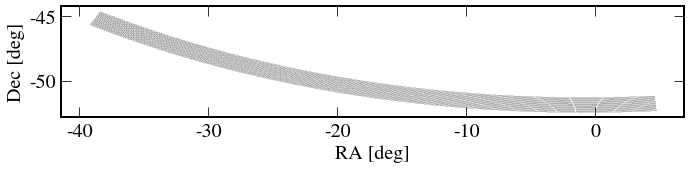

In [5]:
plt.figure(figsize=(10,10))
plt.plot(ra_foot, dec_foot, 'k.', ms=0.1)

plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.gca().set_aspect('equal')

plt.tight_layout()

In [6]:
def find_greatcircle(ra_deg, dec_deg, xi_begin=0):
    """Return rotation matrix that puts a list of ra, dec to the equator"""
    # find the pole
    ra = np.radians(ra_deg)
    dec = np.radians(dec_deg)
    
    rx = np.cos(ra) * np.cos(dec)
    ry = np.sin(ra) * np.cos(dec)
    rz = np.sin(dec)
    r = np.column_stack((rx, ry, rz))
    #r = sph2cart(ra, dec)

    # fit the plane
    x0 = np.array([0, 1, 0])
    lsq = minimize(wfit_plane, x0, args=(r,))
    x0 = lsq.x/np.linalg.norm(lsq.x)
    ra0 = np.arctan2(x0[1], x0[0])
    dec0 = np.arcsin(x0[2])
    
    ra0 += np.pi
    dec0 = np.pi/2 - dec0

    # euler rotations
    R0 = rotmatrix(np.degrees(-ra0), 2)
    R1 = rotmatrix(np.degrees(dec0), 1)
    R2 = rotmatrix(0, 2)
    R = np.dot(R2, np.matmul(R1, R0))
    
    xi, eta = rotate_angles(ra_deg, dec_deg, R)
    
    # put xi = xi_begin at the beginning of the stream
    xi[xi>180] -= 360
    xi += 360
    xi0 = np.min(xi) - xi_begin
    R2 = rotmatrix(-xi0, 2)
    R = np.dot(R2, np.matmul(R1, R0))
    xi, eta = rotate_angles(ra_deg, dec_deg, R)
    
    return R

def wfit_plane(x, r, p=None):
    """Fit a plane to a set of 3d points"""
    
    Np = np.shape(r)[0]
    if np.any(p)==None:
        p = np.ones(Np)
    
    Q = np.zeros((3,3))
    
    for i in range(Np):
        Q += p[i]**2 * np.outer(r[i], r[i])
    
    x = x/np.linalg.norm(x)
    lsq = np.inner(x, np.inner(Q, x))
    
    return lsq

def rotmatrix(theta, i):
    """Returns 3x3 rotation matrix around axis i for angle theta (in deg)"""
    theta = np.radians(theta)
    cth = np.cos(theta)
    sth = np.sin(theta)
    
    sign = (-1)**i
    R2 = np.array([[cth, -sign*sth], [sign*sth, cth]])
    
    R = np.zeros((3,3))
    R[i][i] = 1
    
    if i==0:
        R[1:,1:] = R2
    elif i==1:
        R[0][0] = R2[0][0]
        R[0][2] = R2[0][1]
        R[2][0] = R2[1][0]
        R[2][2] = R2[1][1]
    elif i==2:
        R[:2,:2] = R2
    
    return R

def sph2cart(ra, dec):
    """Convert two angles on a unit sphere to a 3d vector"""
    
    x = np.cos(ra) * np.cos(dec)
    y = np.sin(ra) * np.cos(dec)
    z = np.sin(dec)
    
    return (x, y, z)

def cart2sph(x, y, z):
    """Convert a 3d vector on a unit sphere to two angles"""
    
    ra = np.arctan2(y, x)
    dec = np.arcsin(z)
    
    ra[ra<0] += 2*np.pi
    
    return (ra, dec)

def rotate_angles(a, d, R):
    """Return angles a, d rotated by a 3x3 matrix R
    All angles are in degrees"""
    
    x_, y_, z_ = sph2cart(np.radians(a), np.radians(d))
    X = np.column_stack((x_, y_, z_))
    
    X_rot = np.zeros(np.shape(X))
    for i in range(np.size(x_)):
        X_rot[i] = np.dot(R, X[i])
    
    a_rot, d_rot = cart2sph(X_rot[:, 0], X_rot[:, 1], X_rot[:, 2])
    
    return (np.degrees(a_rot), np.degrees(d_rot))

In [7]:
np.shape(ra_foot)

(13992,)

In [9]:
R = find_greatcircle(ra_foot[::100], dec_foot[::100])
np.save('../data/jhelum_rotmat_init', R)

In [28]:
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import matrix_transpose

class Jhelum(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the track of the PS1-A stream

    For more information about this class, see the Astropy documentation
    on coordinate frames in :mod:`~astropy.coordinates`.

    Parameters
    ----------
    representation : :class:`~astropy.coordinates.BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)

    phi1 : angle_like, optional, must be keyword
        The longitude-like angle corresponding to Orphan's orbit.
    phi2 : angle_like, optional, must be keyword
        The latitude-like angle corresponding to Orphan's orbit.
    distance : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    pm_phi1_cosphi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the longitude-like direction corresponding to
        the Orphan stream's orbit.
    pm_phi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the latitude-like direction perpendicular to the
        Orphan stream's orbit.
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    """
    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'phi1'),
            coord.RepresentationMapping('lat', 'phi2'),
            coord.RepresentationMapping('distance', 'distance')],
        coord.SphericalCosLatDifferential: [
            coord.RepresentationMapping('d_lon_coslat', 'pm_phi1_cosphi2'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')],
        coord.SphericalDifferential: [
            coord.RepresentationMapping('d_lon', 'pm_phi1'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    frame_specific_representation_info[coord.UnitSphericalRepresentation] = \
        frame_specific_representation_info[coord.SphericalRepresentation]
    frame_specific_representation_info[coord.UnitSphericalCosLatDifferential] = \
        frame_specific_representation_info[coord.SphericalCosLatDifferential]
    frame_specific_representation_info[coord.UnitSphericalDifferential] = \
        frame_specific_representation_info[coord.SphericalDifferential]


@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.ICRS, Jhelum)
def icrs_to_jhelum():
    """ Compute the transformation from Galactic spherical to
        heliocentric Jhelum coordinates.
    """
    return R

@frame_transform_graph.transform(coord.StaticMatrixTransform, Jhelum, coord.ICRS)
def jhelum_to_icrs():
    """ Compute the transformation from heliocentric Jhelum coordinates to
        spherical Galactic.
    """
    return matrix_transpose(icrs_to_jhelum())

In [63]:
c_foot = coord.SkyCoord(ra=ra_foot, dec=dec_foot)
c_foot_native = c_foot.transform_to(Jhelum)
c_foot_gal = c_foot.transform_to(coord.Galactic)

In [47]:
corners = np.array([[-10, -5], [-10,5], [35,5], [35,-5]])

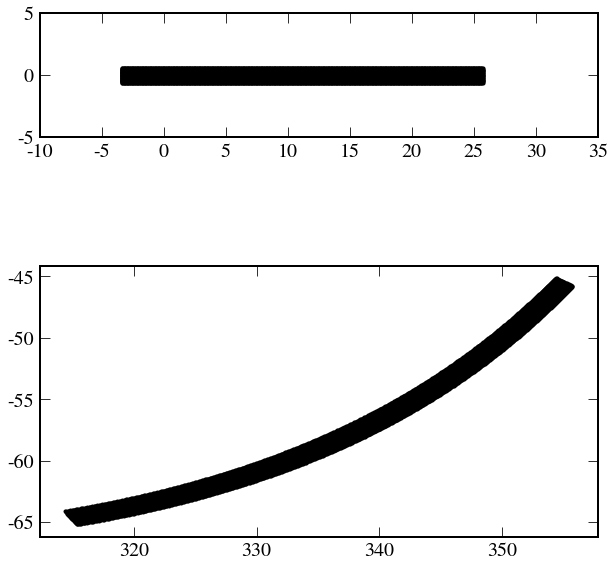

In [69]:
fig, ax = plt.subplots(2,1,figsize=(10,11))

plt.sca(ax[0])
plt.plot(c_foot_native.phi1.wrap_at(wangle), c_foot_native.phi2, 'k.')

plt.xlim(corners[0,0], corners[2,0])
plt.ylim(corners[0,1], corners[1,1])
plt.gca().set_aspect('equal')

plt.sca(ax[1])
plt.plot(c_foot_gal.l, c_foot_gal.b, 'k.')
plt.gca().set_aspect('equal')


In [50]:
c_corner = Jhelum(phi1=corners[:,0]*u.deg, phi2=corners[:,1]*u.deg)

In [56]:
ceq_corner = c_corner.transform_to(coord.ICRS)

In [87]:
class coord_aux():
    def __init__(self, ra, dec):
        self.ra = ra
        self.dec = dec

In [95]:
q_base ='''SELECT * FROM gaiadr2.gaia_source
WHERE parallax < 1 AND
      CONTAINS(POINT('ICRS', ra, dec), 
               POLYGON('ICRS', 
                       {0.ra.degree}, {0.dec.degree}, 
                       {1.ra.degree}, {1.dec.degree}, 
                       {2.ra.degree}, {2.dec.degree}, 
                       {3.ra.degree}, {3.dec.degree})) = 1
'''

In [96]:
print(q_base.format(ceq_corner[3], ceq_corner[2], ceq_corner[1], ceq_corner[0]))

SELECT * FROM gaiadr2.gaia_source
WHERE parallax < 1 AND
      CONTAINS(POINT('ICRS', ra, dec), 
               POLYGON('ICRS', 
                       314.17874961829784, -36.024105782488114, 
                       306.4273084045487, -44.08646356348425, 
                       16.980692418257444, -55.64652802678664, 
                       13.518915072862928, -45.88585536407182)) = 1



### Analyze Gaia data

In [97]:
t = Table(fits.getdata('../data/fits/jhelum-result.fits.gz'))

In [98]:
g = GaiaData(t)
c = coord.SkyCoord(ra=g.ra, dec=g.dec,
                   pm_ra_cosdec=g.pmra, pm_dec=g.pmdec)

In [161]:
cj = c.transform_to(Jhelum)
cj_dist = Jhelum(phi1=cj.phi1, phi2=cj.phi2,
                    distance=np.ones(np.size(cj.phi1))*12*u.kpc,
                    pm_phi1_cosphi2=cj.pm_phi1_cosphi2,
                    pm_phi2=cj.pm_phi2,
                    radial_velocity=[0]*len(cj)*u.km/u.s)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = cj_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
cj = coord.Galactic(rep).transform_to(Jhelum)

In [193]:
cj.pm_phi1_cosphi2.unit

Unit("km rad / (kpc s)")

In [295]:
phi2_mask = (cj.phi2<1*u.deg) & (cj.phi2>0*u.deg) & (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg)
phi2off_mask = (cj.phi2<-3*u.deg) & (cj.phi2>-4*u.deg) & (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg)

color_mask = ((g.phot_g_mean_mag > (5*g.bp_rp + 14*u.mag)) | 
              (g.phot_g_mean_mag < (5*g.bp_rp + 10.5*u.mag))) & (g.bp_rp<1.2*u.mag)
pmeq_mask = (g.pmra>5*u.mas/u.yr) & (g.pmra<10*u.mas/u.yr) & (g.pmdec>-10*u.mas/u.yr) & (g.pmdec<-5*u.mas/u.yr)
pm_mask = ((cj.pm_phi1_cosphi2<-3.5*u.mas/u.yr) & (cj.pm_phi1_cosphi2>-8*u.mas/u.yr) & 
          (cj.pm_phi2<3*u.mas/u.yr) & (cj.pm_phi2>-2.5*u.mas/u.yr))
pm_mask = ((cj.pm_phi1_cosphi2<-4*u.mas/u.yr) & (cj.pm_phi1_cosphi2>-7*u.mas/u.yr) & 
          (cj.pm_phi2<3*u.mas/u.yr) & (cj.pm_phi2>-1*u.mas/u.yr))

/home/ana/install/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/ana/install/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


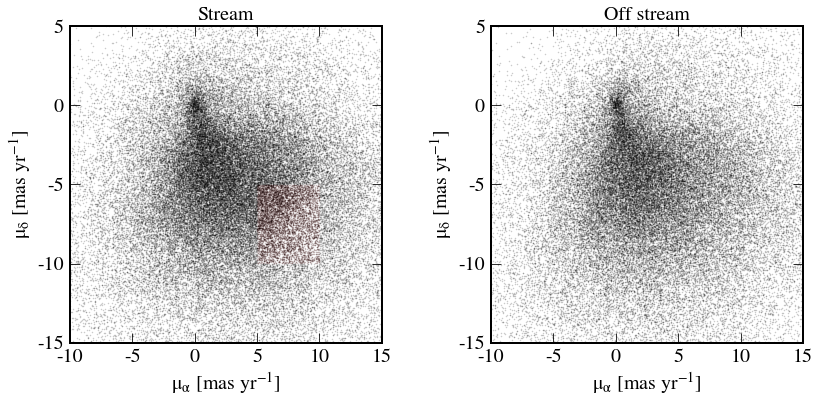

In [296]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

plt.sca(ax[0])
plt.plot(g.pmra[phi2_mask].to(u.mas/u.yr), g.pmdec[phi2_mask].to(u.mas/u.yr), 'k.', ms=1, alpha=0.2)
plt.plot(g.pmra[phi2_mask & pmeq_mask].to(u.mas/u.yr), g.pmdec[phi2_mask & pmeq_mask].to(u.mas/u.yr), 
         'r.', ms=1, alpha=0.05, zorder=0)
# plt.plot(cj.pm_phi1_cosphi2[phi2_mask & pmeq_mask].to(u.mas/u.yr), cj.pm_phi2[phi2_mask & pmeq_mask].to(u.mas/u.yr), 
#          'r.', ms=1, alpha=0.05, zorder=0)

plt.xlim(-10,15)
plt.ylim(-15,5)
plt.xlabel('$\mu_{\\alpha}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\delta}$ [mas yr$^{-1}$]')
plt.title('Stream', fontsize='medium')

plt.sca(ax[1])
plt.plot(g.pmra[phi2off_mask].to(u.mas/u.yr), g.pmdec[phi2off_mask].to(u.mas/u.yr), 'k.', ms=1, alpha=0.2)
# plt.plot(cj.pm_phi1_cosphi2[phi2off_mask & pm_mask].to(u.mas/u.yr), cj.pm_phi2[phi2off_mask & pm_mask].to(u.mas/u.yr), 
#          'r.', ms=1, alpha=0.05, zorder=0)

plt.xlim(-10,15)
plt.ylim(-15,5)
plt.xlabel('$\mu_{\\alpha}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\delta}$ [mas yr$^{-1}$]')
plt.title('Off stream', fontsize='medium')

plt.tight_layout()

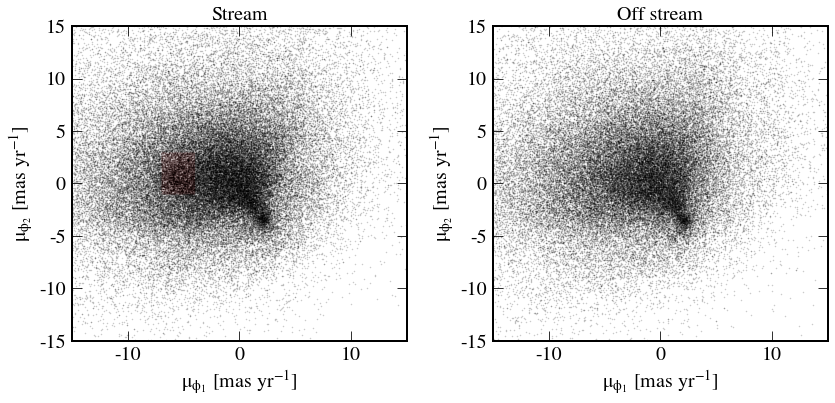

In [297]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

plt.sca(ax[0])
plt.plot(cj.pm_phi1_cosphi2[phi2_mask].to(u.mas/u.yr), cj.pm_phi2[phi2_mask].to(u.mas/u.yr), 'k.', ms=1, alpha=0.2)
plt.plot(cj.pm_phi1_cosphi2[phi2_mask & pm_mask].to(u.mas/u.yr), cj.pm_phi2[phi2_mask & pm_mask].to(u.mas/u.yr), 
         'r.', ms=1, alpha=0.05, zorder=0)
# plt.plot(cj.pm_phi1_cosphi2[phi2_mask & pmeq_mask].to(u.mas/u.yr), cj.pm_phi2[phi2_mask & pmeq_mask].to(u.mas/u.yr), 
#          'r.', ms=1, alpha=0.05, zorder=0)

plt.xlim(-15,15)
plt.ylim(-15,15)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Stream', fontsize='medium')

plt.sca(ax[1])
plt.plot(cj.pm_phi1_cosphi2[phi2off_mask].to(u.mas/u.yr), cj.pm_phi2[phi2off_mask].to(u.mas/u.yr), 
         'k.', ms=1, alpha=0.2)
# plt.plot(cj.pm_phi1_cosphi2[phi2off_mask & pm_mask].to(u.mas/u.yr), cj.pm_phi2[phi2off_mask & pm_mask].to(u.mas/u.yr), 
#          'r.', ms=1, alpha=0.05, zorder=0)

plt.xlim(-15,15)
plt.ylim(-15,15)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Off stream', fontsize='medium')

plt.tight_layout()

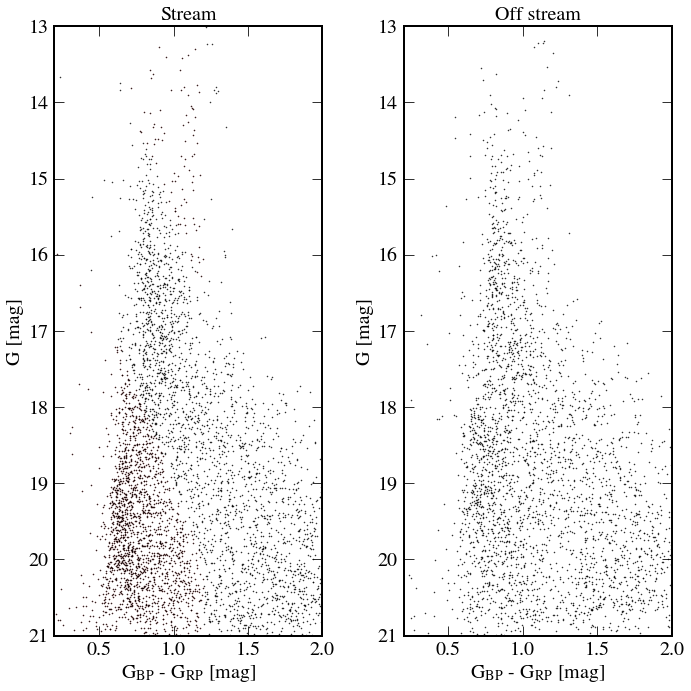

In [298]:
fig, ax = plt.subplots(1,2,figsize=(10,10))
plt.sca(ax[0])
plt.plot(g.bp_rp[phi2_mask & pm_mask], g.phot_g_mean_mag[phi2_mask & pm_mask], 'k.', alpha=0.9, ms=1)
plt.plot(g.bp_rp[phi2_mask & pm_mask & color_mask], g.phot_g_mean_mag[phi2_mask & pm_mask & color_mask], 
         'r.', alpha=0.3, ms=1, zorder=0)
plt.xlim(0.2,2)
plt.ylim(21, 13)
plt.xlabel('$G_{BP}$ - $G_{RP}$ [mag]')
plt.ylabel('G [mag]')
plt.title('Stream', fontsize='medium')

plt.sca(ax[1])
plt.plot(g.bp_rp[phi2off_mask & pm_mask], g.phot_g_mean_mag[phi2off_mask & pm_mask], 'k.', alpha=0.9, ms=1)
plt.xlim(0.2,2)
plt.ylim(21, 13)
plt.xlabel('$G_{BP}$ - $G_{RP}$ [mag]')
plt.ylabel('G [mag]')
plt.title('Off stream', fontsize='medium')

plt.tight_layout()

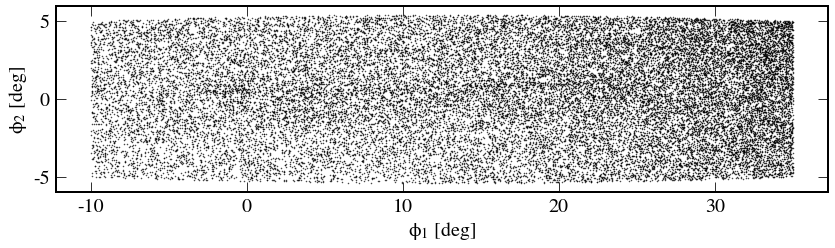

In [299]:
plt.figure(figsize=(12,10))
plt.plot(cj.phi1[pm_mask & color_mask].wrap_at(wangle), cj.phi2[pm_mask & color_mask], 'k.', ms=1, alpha=0.8)
plt.gca().set_aspect('equal')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

plt.tight_layout()

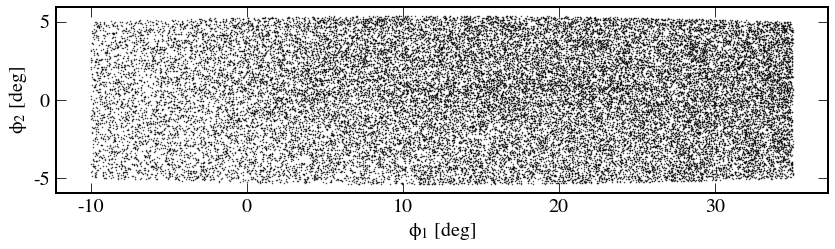

In [300]:
plt.figure(figsize=(12,10))
plt.plot(cj.phi1[pmeq_mask & color_mask].wrap_at(wangle), cj.phi2[pmeq_mask & color_mask], 'k.', ms=1, alpha=0.8)
plt.gca().set_aspect('equal')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

plt.tight_layout()

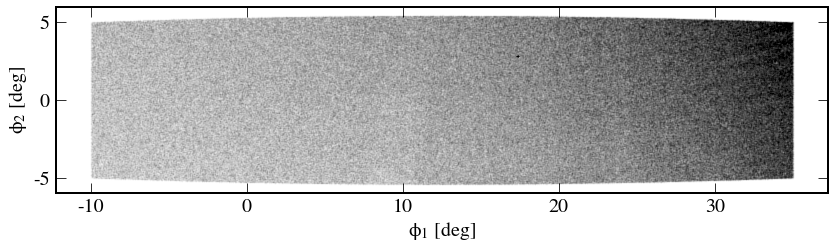

In [301]:
plt.figure(figsize=(12,10))
plt.plot(cj.phi1.wrap_at(wangle), cj.phi2, 'k.', ms=1, alpha=0.01)
plt.gca().set_aspect('equal')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

plt.tight_layout()

In [302]:
ra = coord.Angle(g.ra)

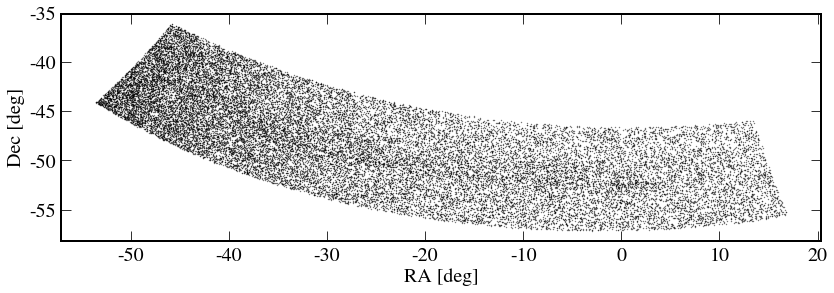

In [303]:
plt.figure(figsize=(12,10))
plt.plot(ra[pm_mask & color_mask].wrap_at(wangle), g.dec[pm_mask & color_mask], 'k.', ms=0.7, alpha=0.7)
plt.gca().set_aspect('equal')

plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')

plt.tight_layout()

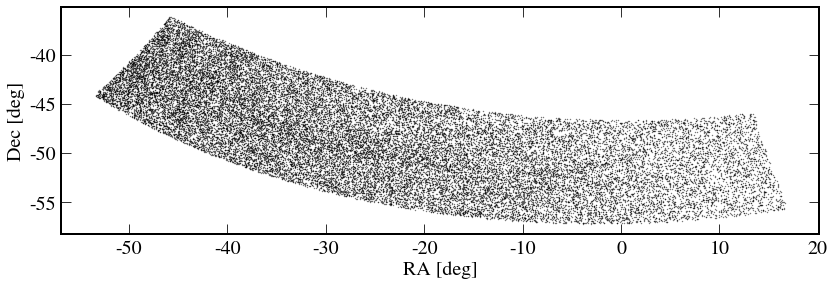

In [304]:
plt.figure(figsize=(12,10))
plt.plot(ra[pmeq_mask & color_mask].wrap_at(wangle), g.dec[pmeq_mask & color_mask], 'k.', ms=0.7, alpha=0.7)
plt.gca().set_aspect('equal')

plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')

plt.tight_layout()